In [121]:
import gymnasium as gym
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt


In [ ]:
class DiscretizeObservation(gym.ObservationWrapper):
    """
    clase que cambia el espacio de observación de continuo a discreto
    """
    def __init__(self, env, bins=(40, 40)):
        super().__init__(env)
        self.bins = bins

        
        self.position_min = self.env.observation_space.low[0]
        self.position_max = self.env.observation_space.high[0]
        self.velocity_min = self.env.observation_space.low[1]
        self.velocity_max = self.env.observation_space.high[1]

        
        self.position_bins = np.linspace(self.position_min, self.position_max, bins[0] - 1)
        self.velocity_bins = np.linspace(self.velocity_min, self.velocity_max, bins[1] - 1)

        # Redefinimos el espacio de observaciones como MultiDiscrete
        self.observation_space = gym.spaces.MultiDiscrete(bins)
    
    def observation(self, observation):
        position, velocity = observation
        # Asigna cada valor continuo a un índice de bin
        pos_idx = np.digitize(position, self.position_bins)
        vel_idx = np.digitize(velocity, self.velocity_bins)
        return np.array([pos_idx, vel_idx], dtype=np.int32)


In [123]:
class DynaQAgent:
    def __init__(self, 
                 n_states,       # tupla: (bins_position, bins_velocity)
                 n_actions, 
                 alpha=0.1, 
                 gamma=0.99, 
                 epsilon=0.1, 
                 planning_steps=5):
        """
        n_states: (n_bins_pos, n_bins_vel)
        n_actions: número de acciones (3 en MountainCar-v0)
        alpha: tasa de aprendizaje
        gamma: factor de descuento
        epsilon: prob. de explorar (política e-greedy)
        planning_steps: cuántas veces se repite la fase de planificación
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.planning_steps = planning_steps

        # Q-table
        self.Q = np.zeros((n_states[0], n_states[1], n_actions))

        # Modelo tabular: dict con llave (s0, s1, a) => valor (r, (ns0, ns1))
        self.model = {}

    def choose_action(self, state):
        """
        Política epsilon-greedy sobre la Q-table.
        state es (s0, s1) discretizado.
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.Q[state[0], state[1], :])

    def update_real_experience(self, state, action, reward, next_state):
        """
        (1) Actualización tipo Q-learning
        (2) Actualización del modelo con la nueva transición
        """
        s0, s1 = state
        ns0, ns1 = next_state

        # Q-learning update
        best_next_action = np.argmax(self.Q[ns0, ns1, :])
        td_target = reward + self.gamma * self.Q[ns0, ns1, best_next_action]
        td_error = td_target - self.Q[s0, s1, action]
        self.Q[s0, s1, action] += self.alpha * td_error

        # Actualizar el modelo
        self.model[(s0, s1, action)] = (reward, (ns0, ns1))

    def planning(self):
        """
        Se repite varias veces: muestreo aleatorio de transiciones
        guardadas en el modelo y actualización Q-learning "simulada".
        """
        for _ in range(self.planning_steps):
            # Escoger aleatoriamente un (s, a) del modelo
            (s0, s1, a) = random.choice(list(self.model.keys()))
            r, (ns0, ns1) = self.model[(s0, s1, a)]

            # Mismo update tipo Q-learning pero usando la transición del modelo
            best_next_action = np.argmax(self.Q[ns0, ns1, :])
            td_target = r + self.gamma * self.Q[ns0, ns1, best_next_action]
            td_error = td_target - self.Q[s0, s1, a]
            self.Q[s0, s1, a] += self.alpha * td_error


In [124]:
def train_dyna_q(num_episodes=500, planning_steps=5, render=False):
    env = gym.make("MountainCar-v0")
    env = DiscretizeObservation(env, bins=(40, 40))

    # Dimensiones de bins para posición y velocidad
    n_bins_position = env.observation_space.nvec[0]
    n_bins_velocity = env.observation_space.nvec[1]
    n_actions = env.action_space.n  # 3 para MountainCar-v0

    # Crear agente Dyna-Q
    agent = DynaQAgent(
        n_states=(n_bins_position, n_bins_velocity),
        n_actions=n_actions,
        alpha=0.2,
        gamma=0.995,
        epsilon=0.1,
        planning_steps=planning_steps
    )

    rewards_per_episode = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            if render:
                env.render()

            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            total_reward += reward

            # Actualizar con experiencia real
            agent.update_real_experience(state, action, reward, next_state)
            # Planificación
            agent.planning()

            state = next_state

        rewards_per_episode.append(total_reward)

        # (Opcional) reducir epsilon con el tiempo
        # agent.epsilon = max(agent.epsilon * 0.99, 0.01)

        # Mostrar progreso
        if (episode+1) % 100 == 0:
            print(f"Episodio {episode+1}/{num_episodes}, Recompensa: {total_reward:.2f}")

    env.close()
    return agent, rewards_per_episode


In [125]:
def plot_rewards(rewards, window=10):
    """
    Grafica la recompensa por episodio y
    su promedio móvil con ventana 'window'.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(rewards, label='Reward por episodio', alpha=0.5)
    
    # Promedio móvil
    if len(rewards) >= window:
        moving_avg = np.convolve(
            rewards, np.ones(window)/window, mode='valid'
        )
        plt.plot(range(window-1, len(rewards)), moving_avg, 
                 color='red', label=f'Media móvil ({window})')
    
    plt.title("Recompensa por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa")
    plt.legend()
    plt.show()


In [126]:
def evaluate_policy(agent, env, n_episodes=10):
    """
    Ejecuta la política del agente (epsilon=0) durante n_episodes
    y devuelve la media y desviación estándar de la recompensa obtenida.
    """
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0  # política puramente greedy

    rewards_eval = []

    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        ep_reward = 0
        while not done:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_reward += reward
            done = terminated or truncated
            state = next_state
        rewards_eval.append(ep_reward)

    agent.epsilon = old_epsilon  # restaurar epsilon

    mean_reward = np.mean(rewards_eval)
    std_reward = np.std(rewards_eval)
    return mean_reward, std_reward


In [127]:
def run_experiment_dyna_q(num_episodes=500, planning_steps=5, n_experiments=10):
    """
    Entrena el agente Dyna-Q y repite el experimento varias veces.
    Reporta media y desviación estándar de la recompensa final.
    """
    # Listas para almacenar la media y std de cada experimento
    means = []
    stds = []

    # Para cada experimento, entrenamos desde cero y evaluamos
    for exp in range(n_experiments):
        print(f"\n=== Experimento {exp+1}/{n_experiments} ===")
        agent, rewards = train_dyna_q(
            num_episodes=num_episodes, 
            planning_steps=planning_steps, 
            render=False
        )

        # Graficar (opcional) la recompensa del último experimento
        if exp == n_experiments - 1:  
            plot_rewards(rewards, window=10)

        # Evaluar política final
        # Creamos un nuevo entorno discretizado para evaluación
        eval_env = gym.make("MountainCar-v0")
        eval_env = DiscretizeObservation(eval_env, bins=(40, 40))

        mean_reward, std_reward = evaluate_policy(agent, eval_env, n_episodes=10)
        means.append(mean_reward)
        stds.append(std_reward)
        print(f"Recompensa (mean ± std) en evaluación: {mean_reward:.2f} ± {std_reward:.2f}")

    # Reporte global tras los n_experiments
    overall_mean = np.mean(means)
    overall_std = np.std(means)

    print("\n=== Resultados finales tras múltiples experimentos ===")
    print(f"Recompensa promedio: {overall_mean:.2f}, Desviación estándar: {overall_std:.2f}")
    print("Tabla de resultados por experimento:")
    for i, (m, s) in enumerate(zip(means, stds), 1):
        print(f"  Exp {i}: {m:.2f} ± {s:.2f}")



=== Experimento 1/10 ===
Episodio 100/1500, Recompensa: -200.00
Episodio 200/1500, Recompensa: -200.00
Episodio 300/1500, Recompensa: -200.00
Episodio 400/1500, Recompensa: -200.00
Episodio 500/1500, Recompensa: -200.00
Episodio 600/1500, Recompensa: -200.00
Episodio 700/1500, Recompensa: -200.00
Episodio 800/1500, Recompensa: -186.00
Episodio 900/1500, Recompensa: -200.00
Episodio 1000/1500, Recompensa: -200.00
Episodio 1100/1500, Recompensa: -200.00
Episodio 1200/1500, Recompensa: -200.00
Episodio 1300/1500, Recompensa: -200.00
Episodio 1400/1500, Recompensa: -200.00
Episodio 1500/1500, Recompensa: -190.00
Recompensa (mean ± std) en evaluación: -196.00 ± 8.61

=== Experimento 2/10 ===
Episodio 100/1500, Recompensa: -200.00
Episodio 200/1500, Recompensa: -200.00
Episodio 300/1500, Recompensa: -200.00
Episodio 400/1500, Recompensa: -200.00
Episodio 500/1500, Recompensa: -200.00
Episodio 600/1500, Recompensa: -200.00
Episodio 700/1500, Recompensa: -200.00
Episodio 800/1500, Recompensa:

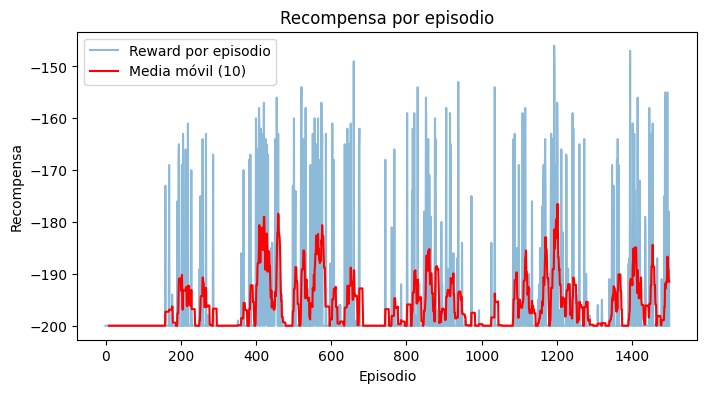

Recompensa (mean ± std) en evaluación: -198.90 ± 3.30

=== Resultados finales tras múltiples experimentos ===
Recompensa promedio: -191.88, Desviación estándar: 6.53
Tabla de resultados por experimento:
  Exp 1: -196.00 ± 8.61
  Exp 2: -200.00 ± 0.00
  Exp 3: -193.30 ± 13.40
  Exp 4: -186.90 ± 11.15
  Exp 5: -179.40 ± 15.98
  Exp 6: -189.30 ± 23.46
  Exp 7: -200.00 ± 0.00
  Exp 8: -187.30 ± 14.94
  Exp 9: -187.70 ± 13.85
  Exp 10: -198.90 ± 3.30


In [128]:
if __name__ == "__main__":
    run_experiment_dyna_q(num_episodes=1500, planning_steps=5, n_experiments=10)
